In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,matplotlib,json,sklearn,topicpy -a Filippo_Valle -g -r -b -w

2025-04-03 08:52:29.982650: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 08:52:30.145781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 08:52:30.340606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-03 08:52:30.483217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 08:52:30.536479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 08:52:30.808112: I tensorflow/core/platform/cpu_feature_gu

Author: Filippo_Valle

Last updated: Thu Apr 03 2025

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

pandas    : 1.5.0
numpy     : 1.23.5
matplotlib: 3.6.0
json      : 2.0.9
sklearn   : 1.1.2
topicpy   : 0.3.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 6.8.0-56-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: c38fecf139bc0c95245a6c091d9ebc5c639c8568

Git repo: git@github.com:fvalle1/topics.git

Git branch: main

Watermark: 2.4.3



In [2]:
import requests as rq
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from topicpy.TCGA_files import get_tcga_tissue
from sklearn import metrics
from topicpy.hsbmpy import *
from topicpy.hsbmpy import normalise_score
import os

## read data

In [3]:
level = 0
algorithm = 'topsbm'
directory = f"./"
L=0
df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_clusters.head()

Cluster 1                             Cluster 2  \
0  AdultCerebellum_1.ACGTTGCCAGACGATCTT  AdultCerebellum_1.CTTCTGCTTCTGCATCCC   
1  AdultCerebellum_1.CATCCCTCTACCGCTCAA  AdultCerebellum_1.ACGAGCAAGCGGCTGTGT   
2  AdultCerebellum_1.AACCTAACACCCTGTGCG  AdultCerebellum_1.ACGAGCAGTCGTGTCGGT   
3  AdultCerebellum_1.TGGATGCCTAGAACGAGC  AdultCerebellum_1.TGCAATATACAGCCTAGA   
4  AdultCerebellum_1.ACGAGCCGCTTGAACGCC  AdultCerebellum_1.ACAATATATGTACCAGAC   

                              Cluster 3                             Cluster 4  \
0  AdultCerebellum_1.TAGTCGCGCACCGTCGGT  AdultCerebellum_1.CTCCATCCGACGCAAAGT   
1  AdultCerebellum_1.TTCCGCATTCCAAACCTA  AdultCerebellum_1.ACAATATGATCACCGACG   
2  AdultCerebellum_1.CTCGCAGGACATGGTACA  AdultCerebellum_1.GCGTCCAATAAAACTTAT   
3  AdultCerebellum_1.CGTATTGCGTCCGCGAAT  AdultCerebellum_1.TACTTCTCGTAATCGGGT   
4  AdultCerebellum_1.CTCGCATTCCGCAATAAA  AdultCerebellum_1.TAGTCGGAATTAGTCCCG   

                        Cluster 5                        Cluster 6  \
0  AdultLung_1.ACCTGAACACCCTCTACC  AdultLiver_1.ACAATATAAGGGGTCGGT   
1  AdultLung_1.CCTTTCGGGCGACGAGTA  AdultLiver_1.CTGTGTAATAAATAGTCG   
2  AdultLung_1.TAGTCGGAGGAGCTGAAA  AdultLiver_1.AGTCGTAGCGAGAACGCC   
3  AdultLung_1.CCAGACCGCTTGAGGACT  AdultLiver_1.GAGGAGGTAATGGTCGGT   
4  AdultLung_1.AGATGGTTGGACCGAGTA  AdultLiver_1.TGCAATTTTAGGTAGAGA   

                         Cluster 7                        Cluster 8  \
0  AdultHeart_1.AAGCGGATCTCTTAGAGA  AdultLiver_1.AACCTAGAGATCTAAGGG   
1  AdultHeart_1.AAGCGGTCGTAACCATCT  AdultLiver_1.ACAATACCGCTAATTTGC   
2  AdultHeart_1.AGGACTCAACAAAGTTTA  AdultLiver_1.ACGTTGCCGCTAGAGATC   
3  AdultLiver_1.ACCTGAGGGTTTATTCCA  AdultLiver_1.CTCGCAATCAACCAACAA   
4  AdultHeart_1.CTCGCACGTATTTGAAGC  AdultLiver_1.CTCGCAGTAATGGTCGGT   

                        Cluster 9  
0  AdultLung_1.TCGGGTGTGGTACCATCT  
1  AdultLung_1.CGAGTAGTCCCGCGTGGC  
2  AdultLung_1.ATGCTTGTCCCGCCTAGA  
3  AdultLung_1.TCAAAGTGCAATTATTGT  
4  AdultLung_1.ATGCTTCGCACCAGGGTC

In [4]:
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0]).dropna(axis=1, how='all').dropna(axis=0, how='all')
samples = pd.read_csv("%s/%s/%s_level_1_clusters.csv"%(directory,algorithm,algorithm), header=[0]).astype(str).values.ravel()
samples=samples[samples!="nan"]
df_files = df_files.reindex(index=samples).dropna(how="all", axis=0).fillna("unknown")
labels = df_files.columns
labels

Index(['Sample', 'Batch', 'Cluster_id', 'Ages', 'Development_stage', 'Method',
       'Gender', 'Source', 'Biomaterial', 'Name', 'ident', 'Celltype'],
      dtype='object')

In [5]:
samples

array(['AdultCerebellum_1.ACGTTGCCAGACGATCTT',
       'AdultCerebellum_1.CTTCTGCTTCTGCATCCC',
       'AdultCerebellum_1.TAGTCGCGCACCGTCGGT', ...,
       'AdultLung_1.TCTACCCATGATTCACTT', 'AdultLung_1.CAACAATCGTAACCATCT',
       'AdultLung_1.CTGAAATTCCGCACCTGA'], dtype=object)

In [6]:
labels=['Biomaterial', "Celltype"]

In [7]:
from topicpy.hsbmpy import *

In [7]:
scores = {}
for label in labels:
    scores[label] = get_scores(directory, labels, verbose=False)[label]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')
norm_scores = scores.copy()
normalise_score(norm_scores, base_algorithm="shuffle")

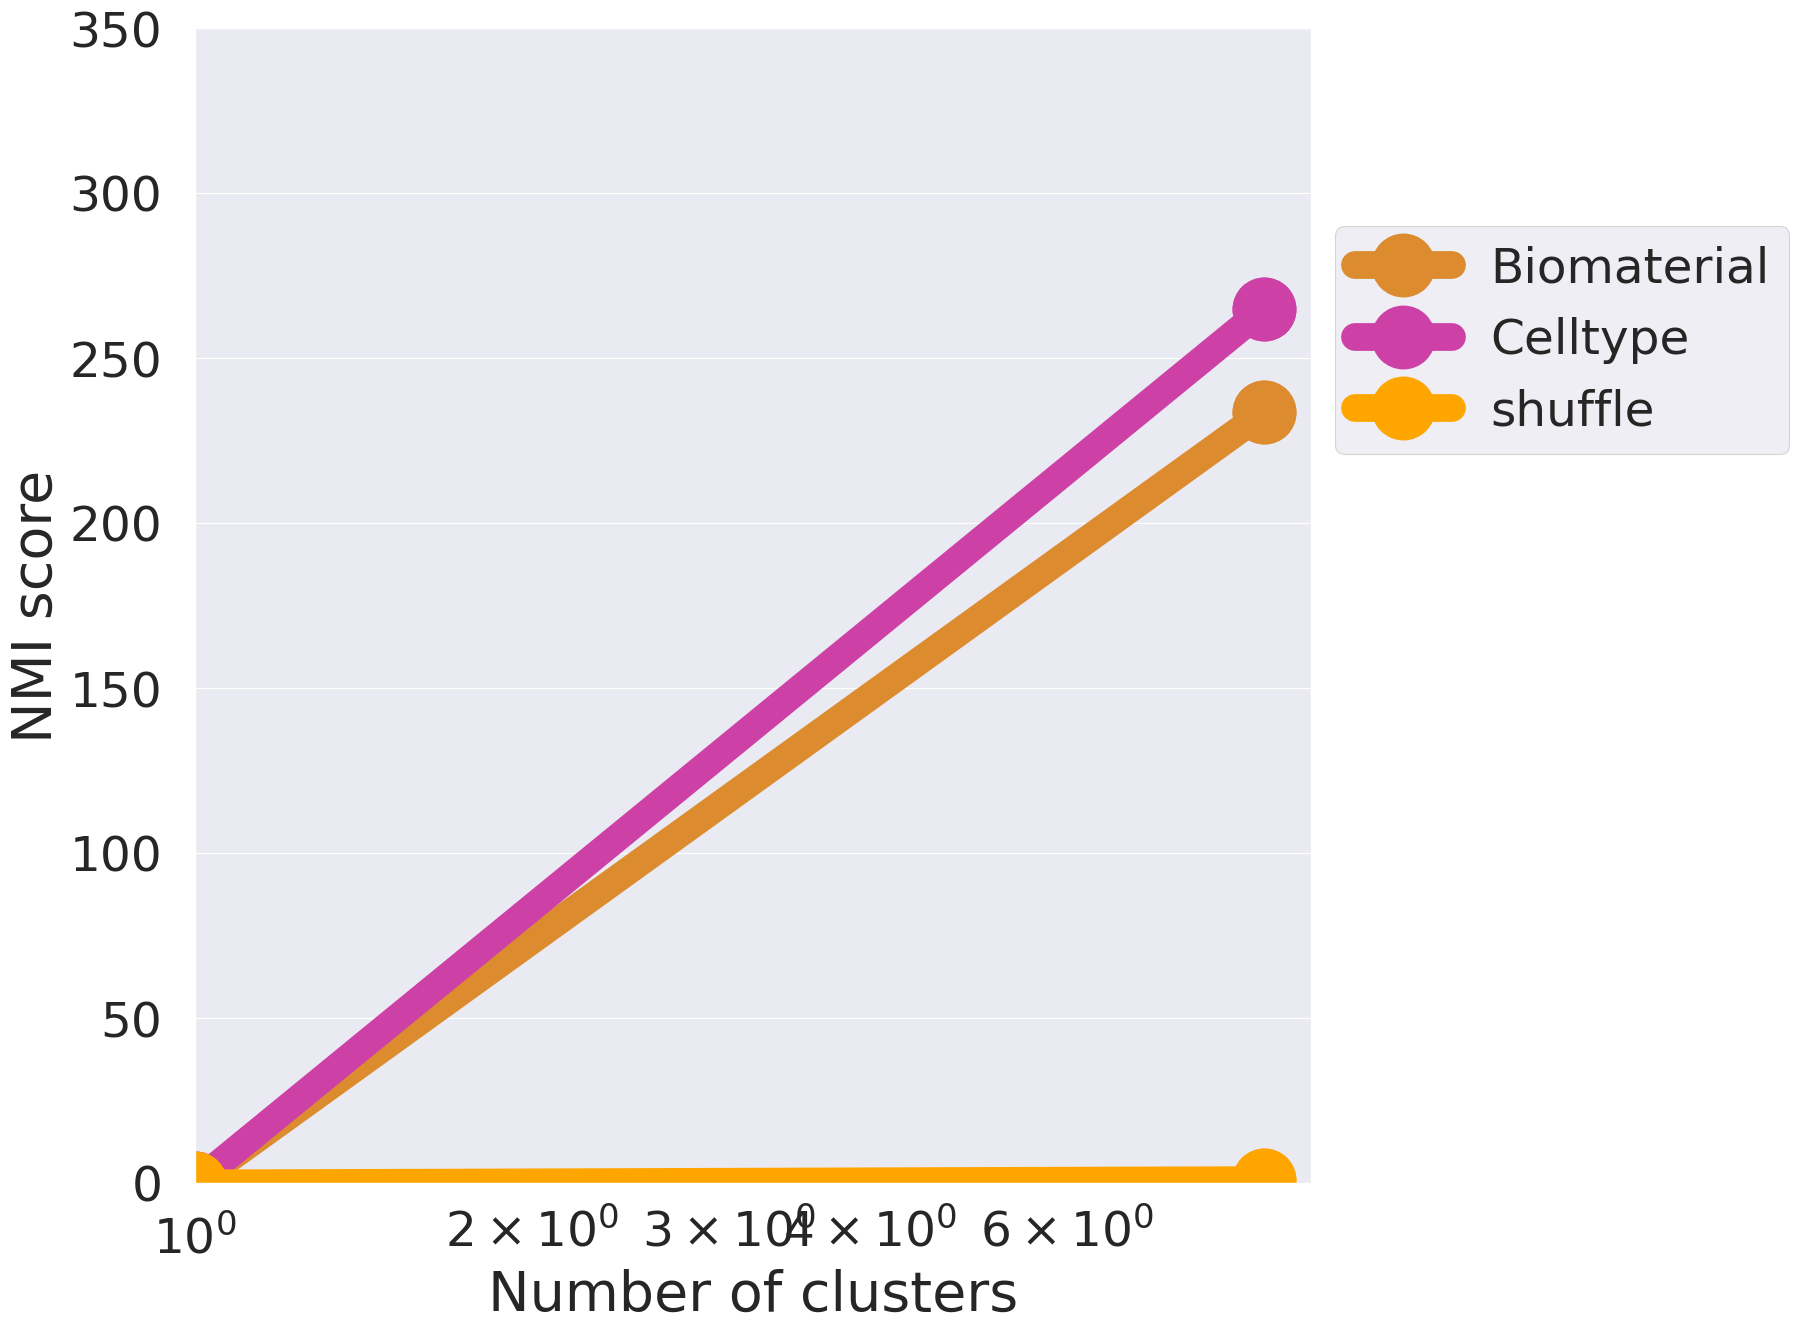

In [13]:
fig=plt.figure(figsize=(18,15))
ax = fig.subplots(1)
add_score_lines(ax,scores,V="norm_V", labels=labels+["shuffle"], alpha=1)
ax.set_xscale('log')
ax.set_ylim(0,350)

plt.show()
# fig.savefig("%s/metric_scores_hierstructure.pdf"%(directory))

In [20]:
data = {}
for alg in ["topsbm", "lda", "wgcna", "tm", "hierarchical-log"]:
    data[alg] = []
    print(alg)
    for i in range (10):
        scores = {}
        label = "Celltype"
        scores[label] = get_scores(directory, labels, verbose=False, algorithm=alg)[label]
        scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm=alg)
        norm_scores = scores.copy()
        normalise_score(norm_scores, base_algorithm="shuffle")
        data[alg].append(scores)

topsbm
lda
wgcna
tm
hierarchical-log


In [30]:
import pickle
# with open("scoresstat_celltype.pkl", 'wb') as f:
#     pickle.dump(data, f)
with open("scoresstat.pkl", 'rb') as f:
    data = pickle.load(f)

In [31]:
class Painter():
    def __init__(self):
        self.count = 0

        self.colors = ["#a257d4",
                "#e090bf",
                "#64c9a3",
                "#4b68ae",
                "#dc8c2f",
                "#cd41a7",
                "#d9344f",
                "#bc599a",
                "#afa1e8",
                "#48c1d8",
                "#b54545",
                "#919233",
                "#9a78be"]
        
    def __next__(self):
        c = self.colors[self.count%len(self.colors)]
        self.count += 1
        return c
    
colors = Painter()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


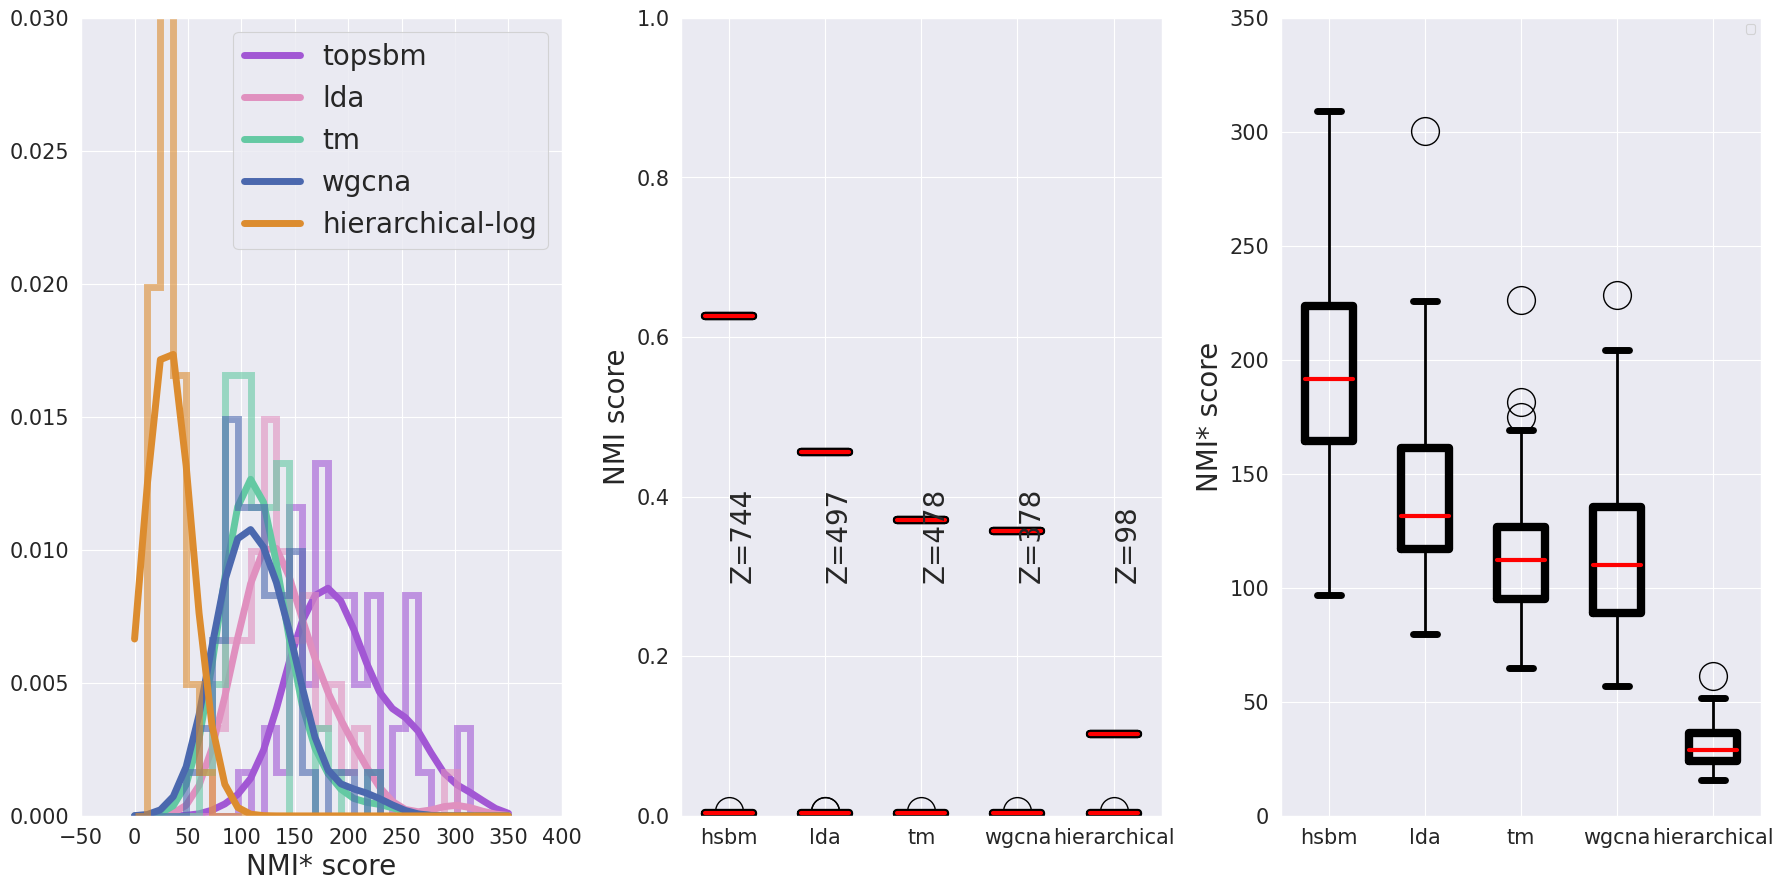

In [34]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
colors = Painter()

p_value = lambda z_score: 2 * (1 - norm.cdf(abs(z_score)))
label = labels[0]
alg_labels = [alg.replace("topsbm", "hsbm").replace("-log","") for alg in data.keys()]

fig, axs = plt.subplots(1, 3, figsize=(18,9))

ax = axs[0]
kwargs=dict(linewidth=5, density=True)
bins = np.linspace(0,350,30)

for alg in data.keys():
    c = next(colors)
    X = np.max([d[label]["norm_V"] for d in data[alg]], axis=1)
    ax.hist(X, histtype="step", stacked=True, bins=bins, alpha=0.6, color=c, **kwargs)
    kde = KernelDensity(kernel='gaussian', bandwidth=20).fit(X.reshape(-1,1))
    
    ax.plot(bins, np.exp(kde.score_samples(bins.reshape(-1,1))), label=alg, color=c, lw=5)


ax.set_ylim(0,0.03)
ax.legend(fontsize=20)
ax.set_xlabel("NMI* score", fontsize=20)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize=15)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=15)



kwargs = dict(flierprops={"c":"gray", "ms":20, "lw":5}, boxprops = {"lw":6}, whiskerprops={"lw":2}, capprops={"lw":5}, medianprops={"c":"red", "lw":3})

ax = axs[2]
ax.boxplot([np.max([d[label]["norm_V"] for d in data[alg]], axis=1) for alg in data.keys()], **kwargs)

ax.set_xticks(list(range(1,6)), alg_labels, rotation=0, fontsize=15)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=15)
ax.legend()
ax.set_ylabel("NMI* score", fontsize=20)

ax = axs[1]
ax.boxplot([np.max([d[label]["V"] for d in data[alg]], axis=1) for alg in data.keys()], **kwargs)
ax.boxplot([np.max([d["shuffle"]["V"] for d in data[alg]], axis=1) for alg in data.keys()], **kwargs)

for i,alg in enumerate(data.keys()):
    x1 = np.max([d[label]["V"] for d in data[alg]], axis=1)
    x2 = np.max([d["shuffle"]["V"] for d in data[alg]], axis=1)
    Z = np.abs(np.mean(x1) - np.mean(x2)) / np.sqrt(1e-10+np.var(x1) + np.var(x2))
    ax.text(i+1, 0.3, "Z={:.0f}".format(Z), fontsize=20, rotation=90)

ax.set_xticks(list(range(1,6)), alg_labels, rotation=0, fontsize=15)
ax.set_ylim(0,1)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=15)

ax.set_ylabel("NMI score", fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig("%s/metric_scores_comparison_box_sc.pdf"%(directory))

In [13]:
plt.rcParams['figure.facecolor'] = 'white'  # Set figure background globally
plt.rcParams['axes.facecolor'] = 'white'   # Set axes background globally
from scipy.stats import norm

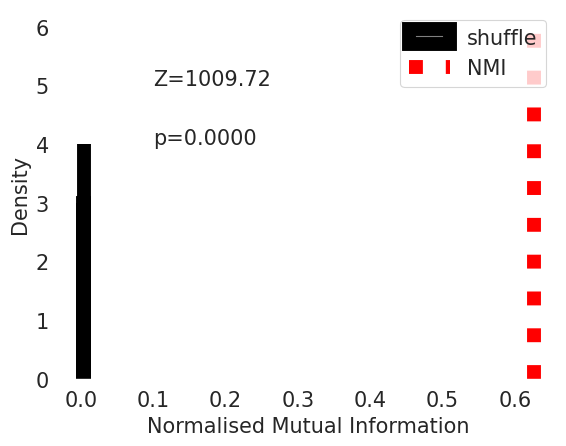

In [14]:
idx = 0

fig = plt.figure()

plt.hist([d["shuffle"]["V"][idx] for d in data], lw=10, edgecolor="black", color="gray", bins=3, label="shuffle")

plt.vlines(data[0]["Biomaterial"]["V"][idx], 0, 6, color="red", lw=10, ls=":", label="NMI")

x1 = [d["shuffle"]["V"][idx] for d in data]
x2 = data[0]["Biomaterial"]["V"][idx]

Z = np.abs(np.mean(x1)-x2)/np.std(x1)
p_value = 2 * (1 - norm.cdf(abs(Z)))

plt.text(0.1, 5, "Z=%.2f"%Z, fontsize=15)
plt.text(0.1, 4, "p=%.4f"%p_value, fontsize=15)

plt.xlabel("Normalised Mutual Information", fontsize=15)
plt.ylabel("Density", fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [15]:
label = labels[0]
scores = {}
scores['hsbm'] = get_scores(directory, labels, df_files=df_files, algorithm = "topsbm", verbose=False)[label]
scores['hierarchical'] = get_scores(directory, labels, algorithm='hierarchical-log', verbose=False)[label]
scores['lda'] = get_scores(directory, labels, algorithm='lda', verbose=False)[label]
scores['tm']=get_scores(directory, labels, algorithm='tm', verbose=False)[label]
scores['wgcna']=get_scores(directory, labels, algorithm='wgcna', verbose=False)[label]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm='topsbm')
normalise_score(scores, base_algorithm="shuffle")

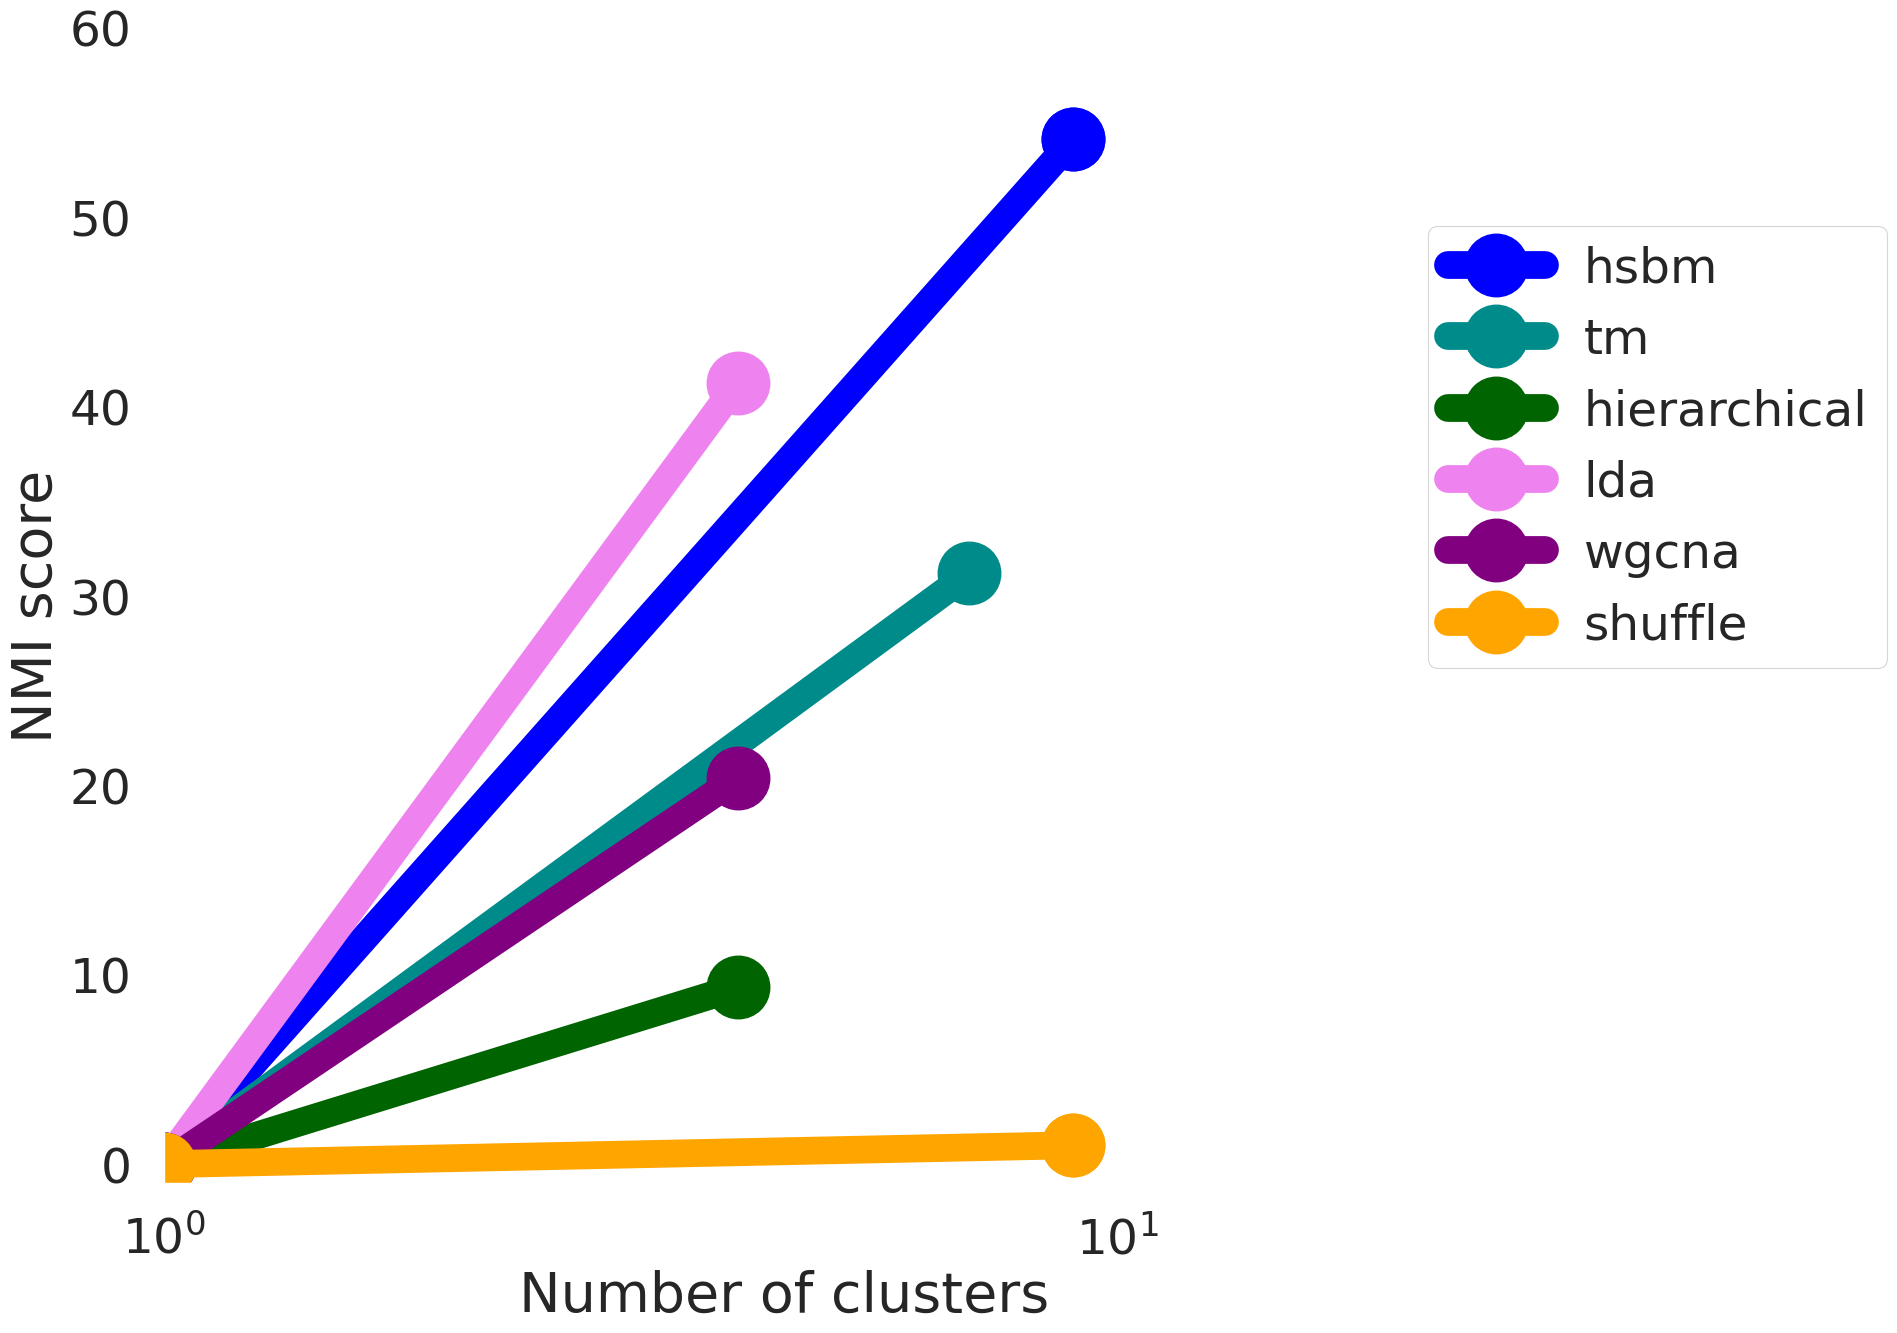

In [25]:
fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=['hsbm', 'tm', 'hierarchical', 'lda', 'wgcna', 'shuffle'])
#ax.set_xscale('linear')
plt.xlim(1,20)
plt.ylim(-1,60)
plt.show()
# fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

In [31]:
label = labels[0]
scores = {}
scores['hsbm'] = get_scores(directory, labels, df_files=df_files, algorithm = "topsbm", verbose=False)[label]
scores['hierarchical'] = get_scores(directory, labels, algorithm='hierarchical-log', verbose=False)[label]
scores['lda'] = get_scores(directory, labels, algorithm='lda', verbose=False)[label]
scores['tm']=get_scores(directory, labels, algorithm='tm', verbose=False)[label]
scores['wgcna']=get_scores(directory, labels, algorithm='wgcna', verbose=False)[label]
scores['hsbm-ct'] = get_scores(directory, labels, df_files=df_files, algorithm = "topsbm", verbose=False)[labels[1]]
scores['hierarchical-ct'] = get_scores(directory, labels, algorithm='hierarchical-log', verbose=False)[labels[1]]
scores['lda-ct'] = get_scores(directory, labels, algorithm='lda', verbose=False)[labels[1]]
scores['tm-ct']=get_scores(directory, labels, algorithm='tm', verbose=False)[labels[1]]
scores['wgcna-ct']=get_scores(directory, labels, algorithm='wgcna', verbose=False)[labels[1]]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm='topsbm')
normalise_score(scores, base_algorithm="shuffle")

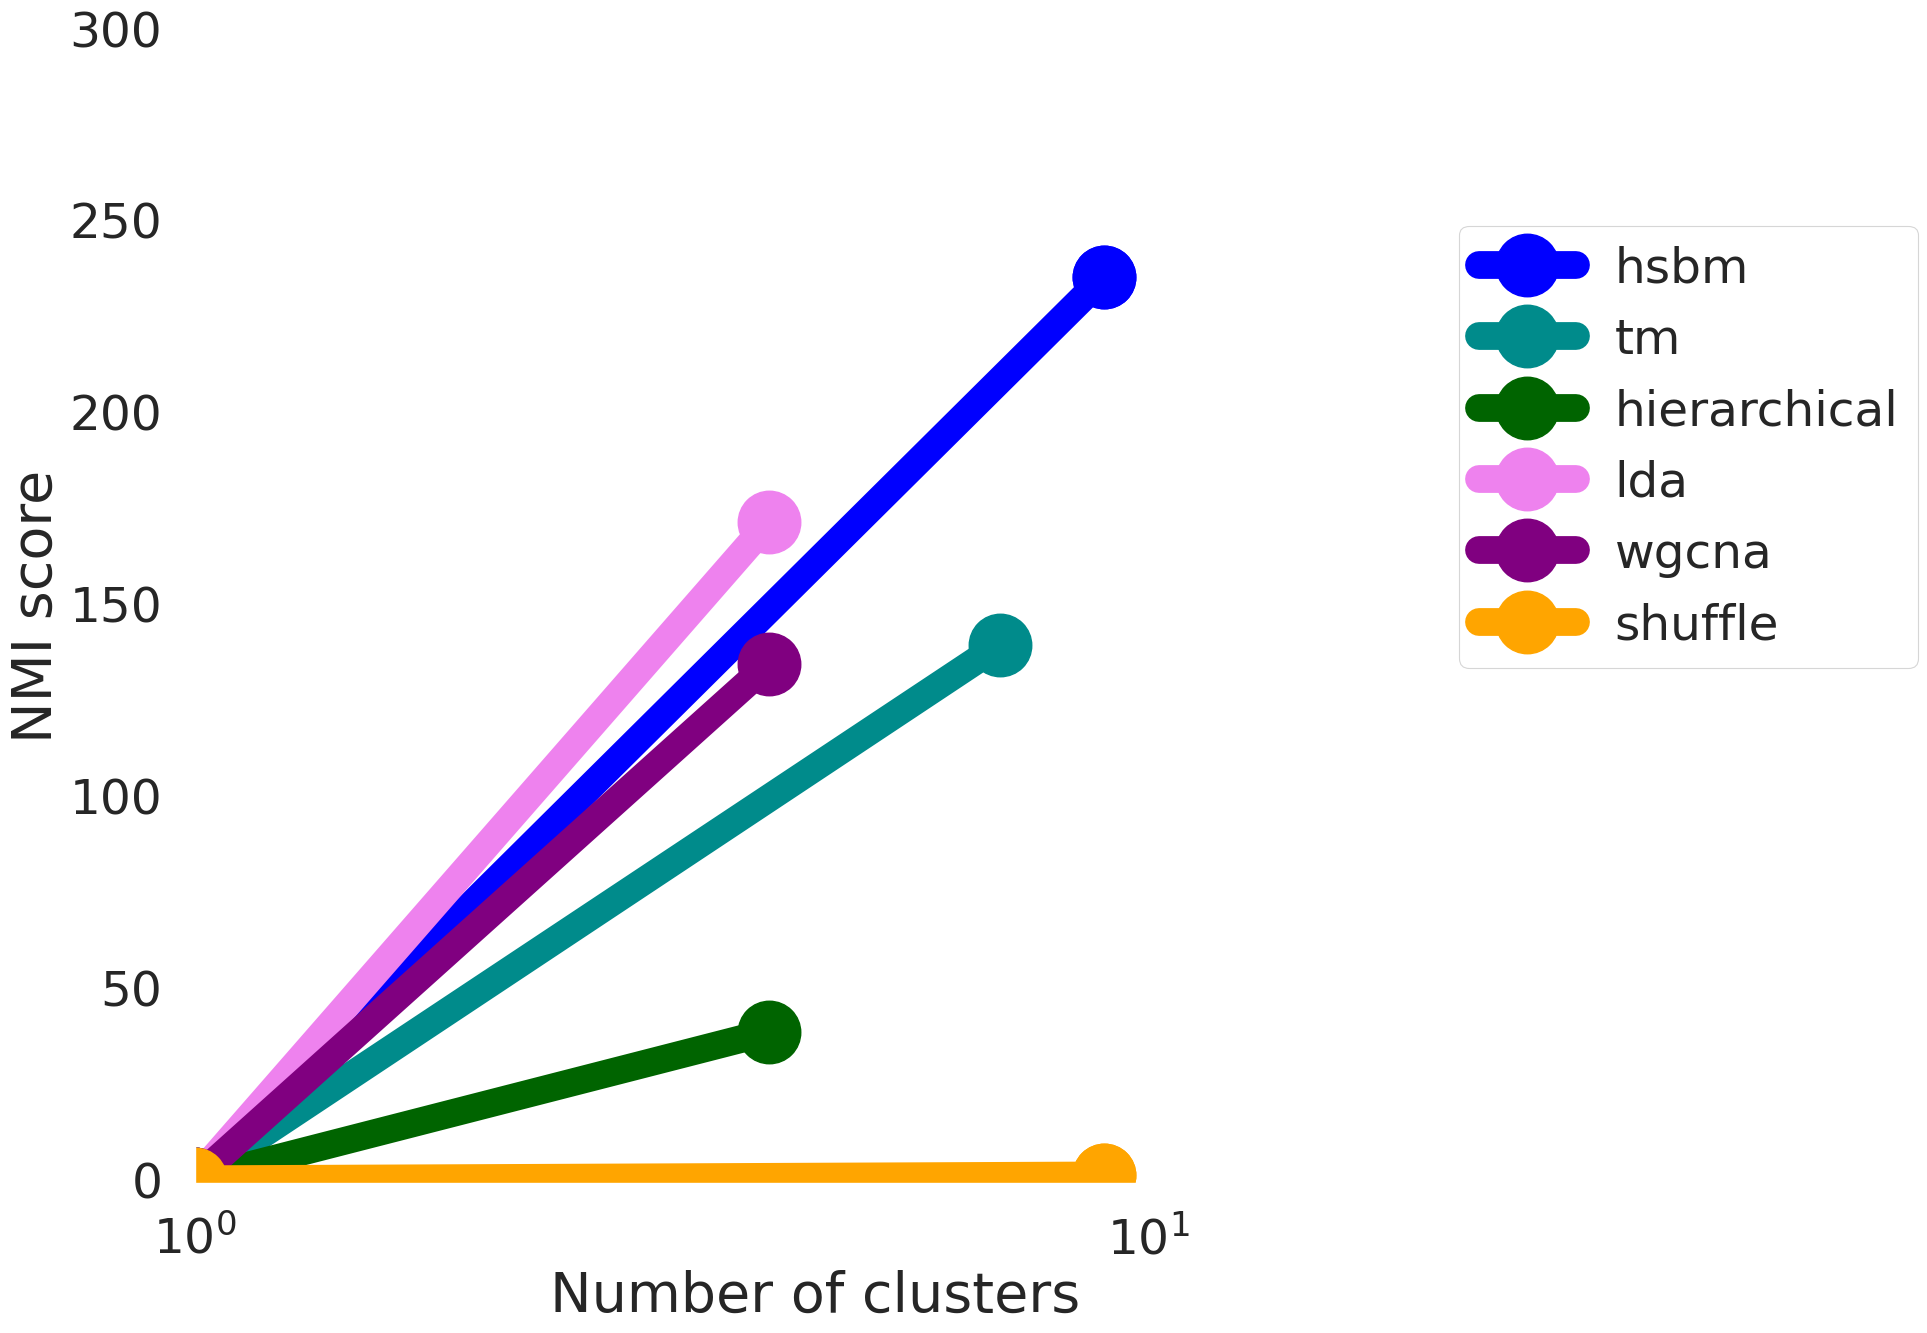

In [55]:
fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=['hsbm', 'tm', 'hierarchical', 'lda', 'wgcna', 'shuffle'])
#ax.set_xscale('linear')
plt.xlim(1,20)
plt.ylim(-1,300)
plt.show()
# fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

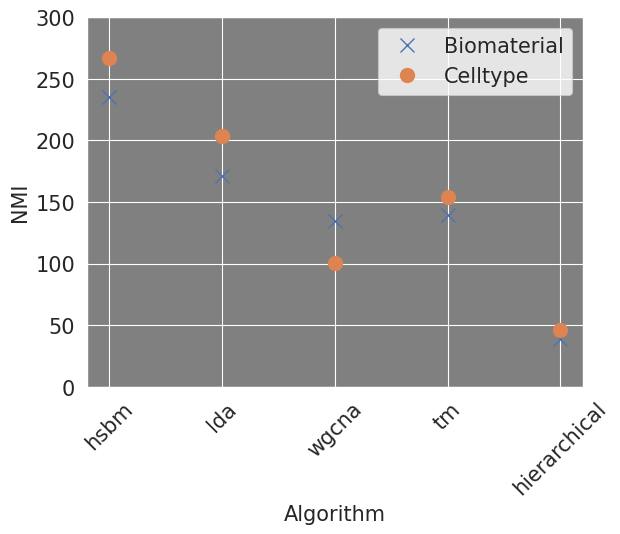

<Figure size 640x480 with 0 Axes>

In [65]:
fig,ax = plt.subplots()
ax.patch.set_facecolor('gray')

ax.plot(list(range(5)),
    [max(scores[alg]["norm_V"]) for alg in ["hsbm", "lda", "wgcna", "tm", "hierarchical"]],
    lw=0,
    ms=10,
    marker='x',
    label=labels[0])
ax.plot(list(range(5)),
    [max(scores[alg+"-ct"]["norm_V"]) for alg in ["hsbm", "lda", "wgcna", "tm", "hierarchical"]],
    lw=0,
    ms=10,
    marker='o',
    label=labels[1])

ax.legend(fontsize=15)

ax.set_ylabel("NMI* score", fontsize=15)
ax.set_xlabel("Algorithm", fontsize=15)
ax.set_xticks(list(range(5)), ["hsbm", "lda", "wgcna", "tm", "hierarchical"], rotation=45, fontsize=15)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=15)
ax.set_ylim(0,300)

plt.show()
plt.tight_layout()
fig.savefig("%s/metric_scores.pdf"%(directory))

# Topic dist

In [4]:
os.getcwd()

'/home/jovyan/work/research/topics/datasets/single-cell'

In [37]:
algorithm = "topsbm"
l =0

In [38]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,l))
t_size = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,l), index_col=0).apply(lambda topic: sum((topic>0).astype(int))).mean()
df_files = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
label = "Celltype"
if label not in df_files.columns:
    raise AttributeError(f"{label} not valid. Available: {df_files.columns}")
print("Working at level %d with %d topics and average size: %d"%(l,df_topics.shape[1]-1, round(t_size)))

Working at level 0 with 20 topics and average size: 150


In [39]:
for sample in df_topics.index.values:
    try:
        df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)[label]))
    except:
        print(*sys.exc_info())
        print(sample)
        df_topics.at[sample,'tissue']="unknown"

In [40]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
df_cmap = df_cmap.subtract(df_cmap.mean(axis=1),axis=0)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

In [41]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
order = df_topics.mean(0).sort_values(ascending=False)
df_topics = df_topics.reindex(columns=order.index)
df_topics.columns = ["Topic %d"%(t+1) for t,_ in enumerate(df_topics.columns)]
for sample in df_topics.index.values:
    try:
        df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)[label])
    except:
        print(sample)

In [42]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
order = df_topics.mean(0).sort_values(ascending=False)
df_topics = df_topics.reindex(columns=order.index)
df_topics.columns = ["Topic %d"%(t+1) for t,_ in enumerate(df_topics.columns)]
for sample in df_topics.index.values:
    try:
        df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)[label])
    except:
        print(sample)

AT1 cell 
AT2 cell
Activated T cell
Astrocyte(Bergmann glia)
B cell (Plasmocyte)_IGHM/HG high
Endothelial cell_TMEM100 high
Excitatory neuron
Fibroblast
Fibroblast_A2M high
M2 Macrophage
Macrophage
Macrophage_M2
Myeloid cell
Neutrophil_CD177 high
Oligodendrocyte
Oligodendrocyte progenitor cell
Sinusoidal endothelial cell
Smooth muscle cell
Ventricle cardiomyocyte


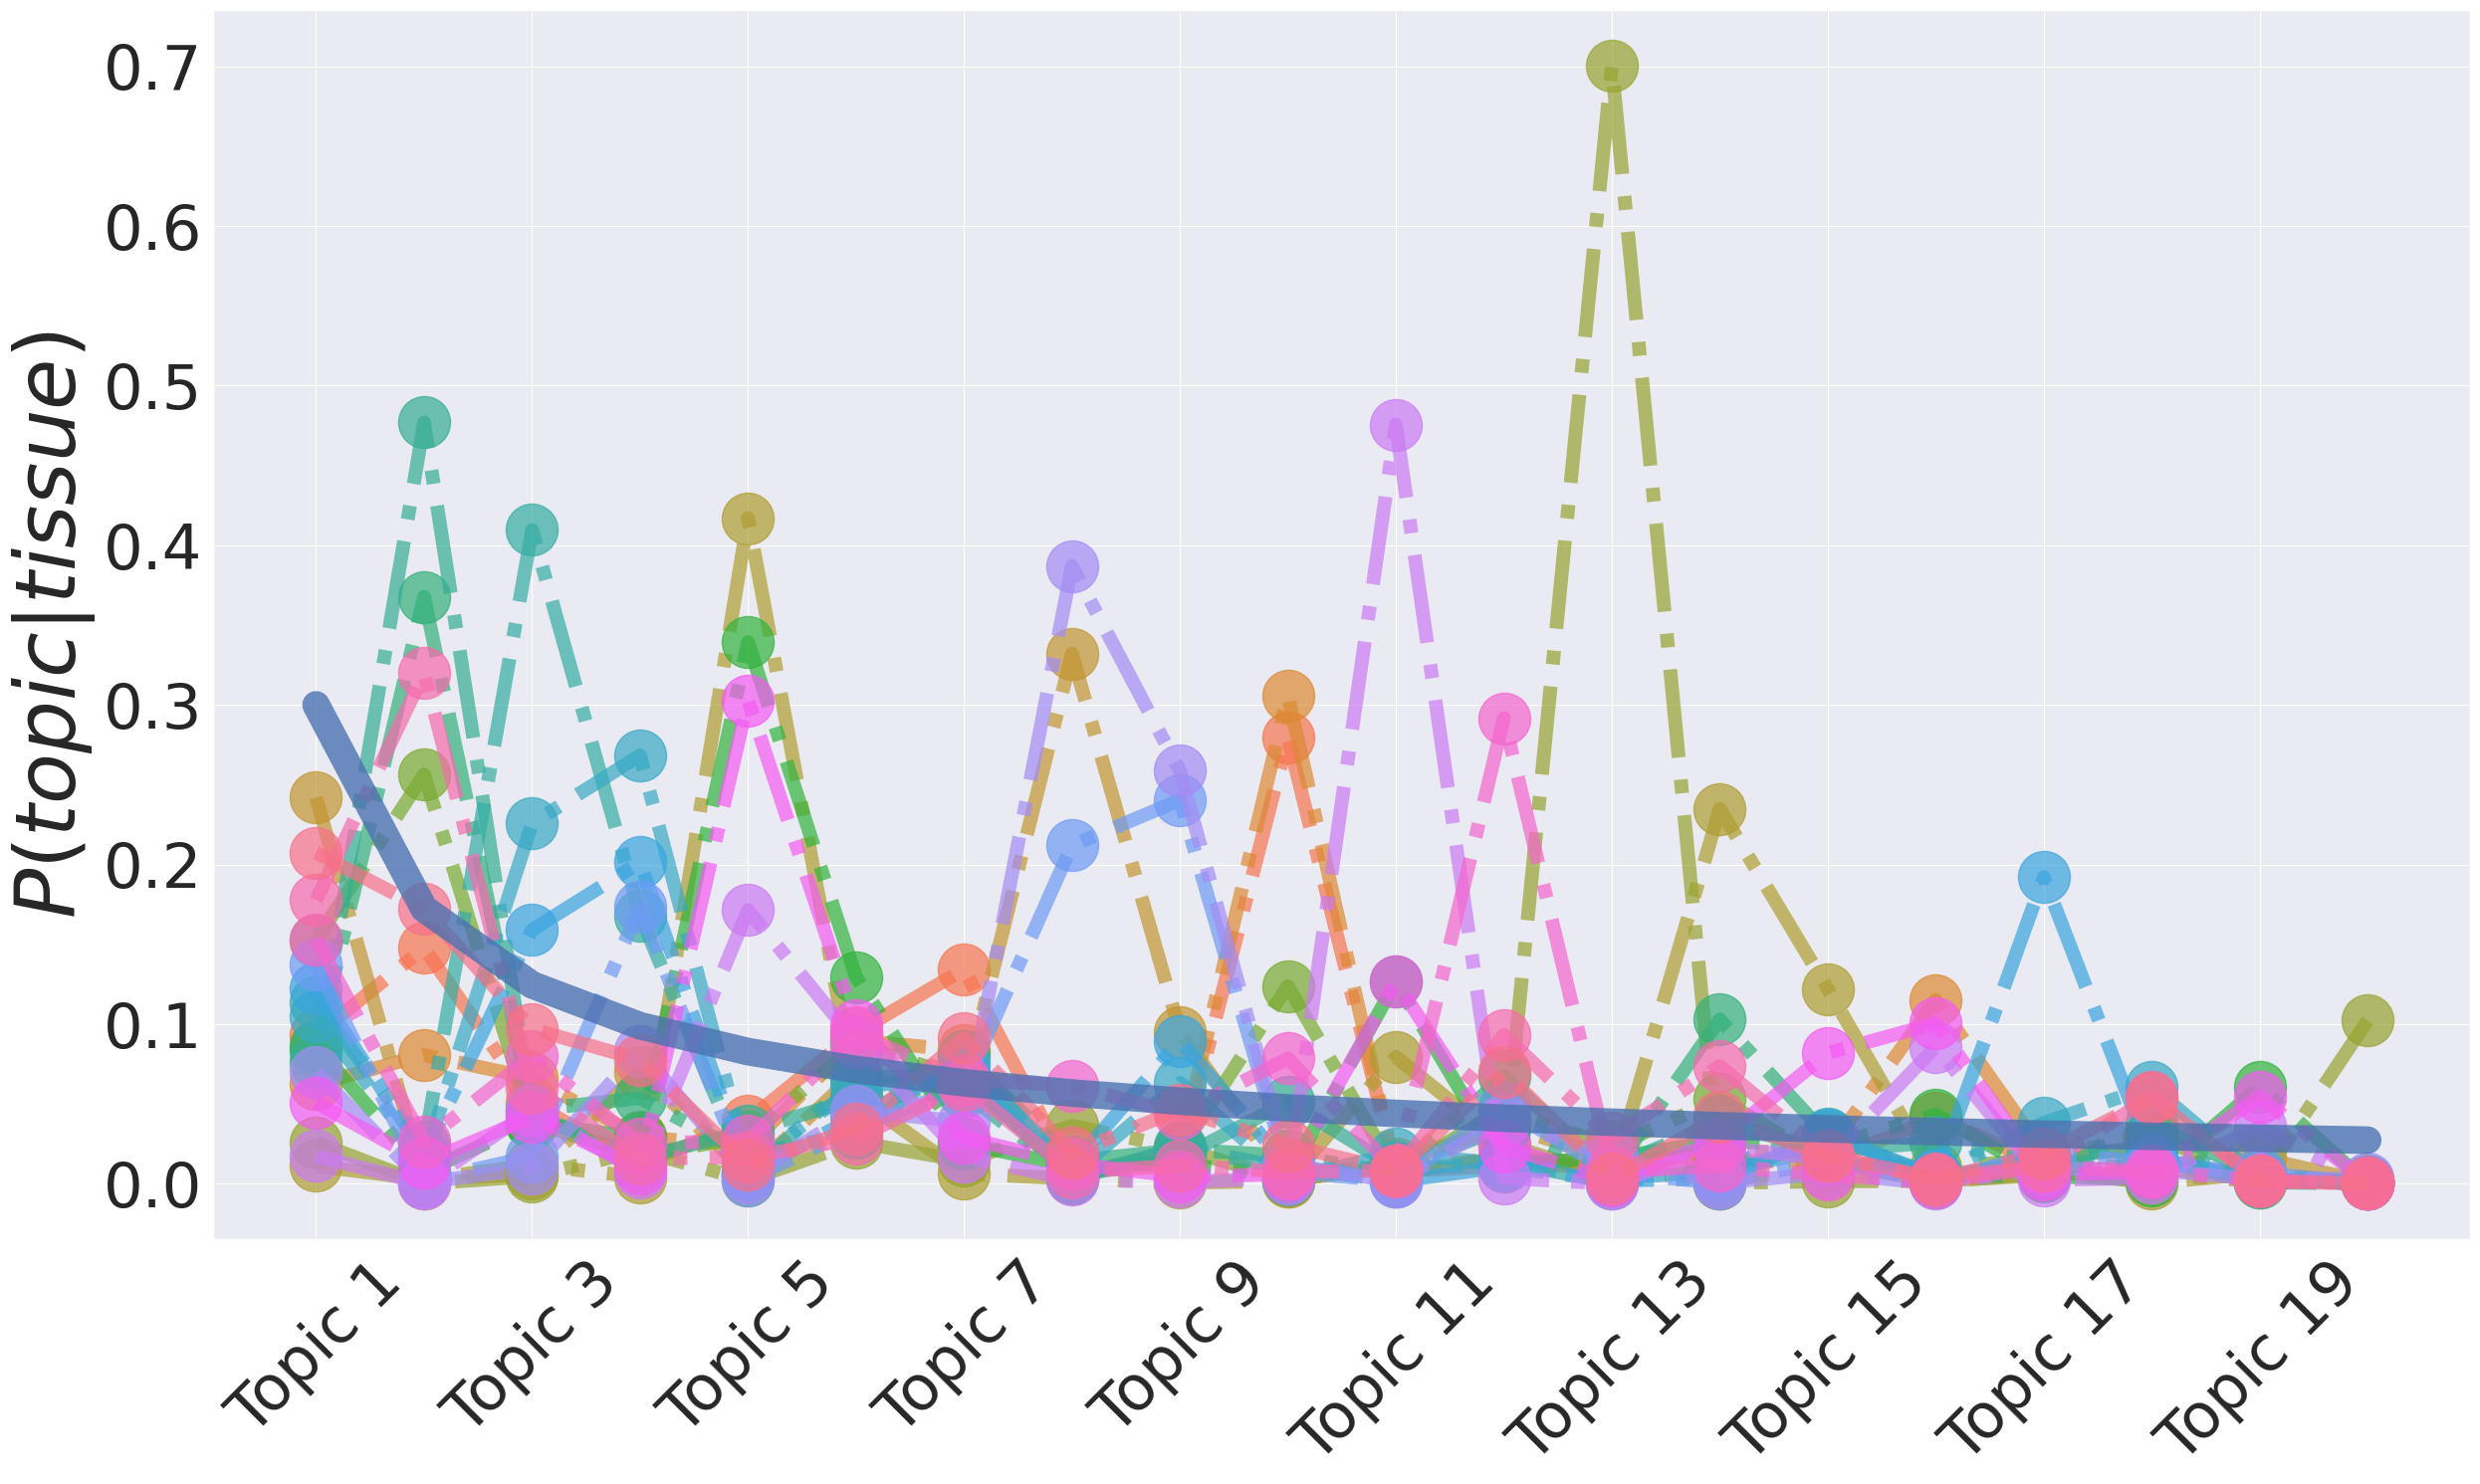

In [43]:
log = False

fig,ax = plt.subplots(figsize=(25,15))
for tissue in np.sort(df_topics['tissue'].unique()):
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        ax.plot(np.arange(1, df_topics.shape[1],step=1), df_topics[df_topics['tissue']==tissue].set_index("tissue").mean(axis=0), ls=ls,marker=marker, lw=10, ms=75, alpha=0.7,label=tissue, c=network_lut[tissue])
    except:
        print(*sys.exc_info())
ax.set_ylabel("$P(topic | tissue)$", fontsize=60)
#plt.xscale('log')
#plt.yscale('log')

if algorithm == "topsbm":
    ax.plot(np.arange(1, df_topics.shape[1],step=1),[0.3*i**-0.8 for i in np.arange(1, df_topics.shape[1],step=1)], lw=20, alpha=0.8)

ax.set_xticks(np.arange(1, df_topics.shape[1],step=2))
ax.set_xticklabels(df_topics.columns[:-1:2], rotation=45)
ax.tick_params(labelsize=45)

if log:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks(np.arange(1, df_topics.shape[1],step=1))
    ax.set_xticklabels(df_topics.columns[:-1], rotation=75)
    ax.tick_params(labelsize=40)
    ax.set_xlim(1,df_topics.shape[1])
    
    
# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(fontsize=25, ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend(fontsize=45, ncol=1, loc='best')


plt.tight_layout()
plt.show()
fig.savefig("%s/%slifeplot_level%d%s%s.pdf"%(algorithm,algorithm,l,label,"_log" if log else ""))

# UMAP

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.cm import ColormapRegistry

In [12]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,L), header=[0], index_col=1).drop(['i_doc'], axis=1)
df_sc_data = pd.read_csv("%s/mainTable.csv"%(directory), header=[0], index_col=0)
adata_sc = sc.AnnData(df_sc_data.values.T)

In [15]:
sc.pp.pca(adata_sc)
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


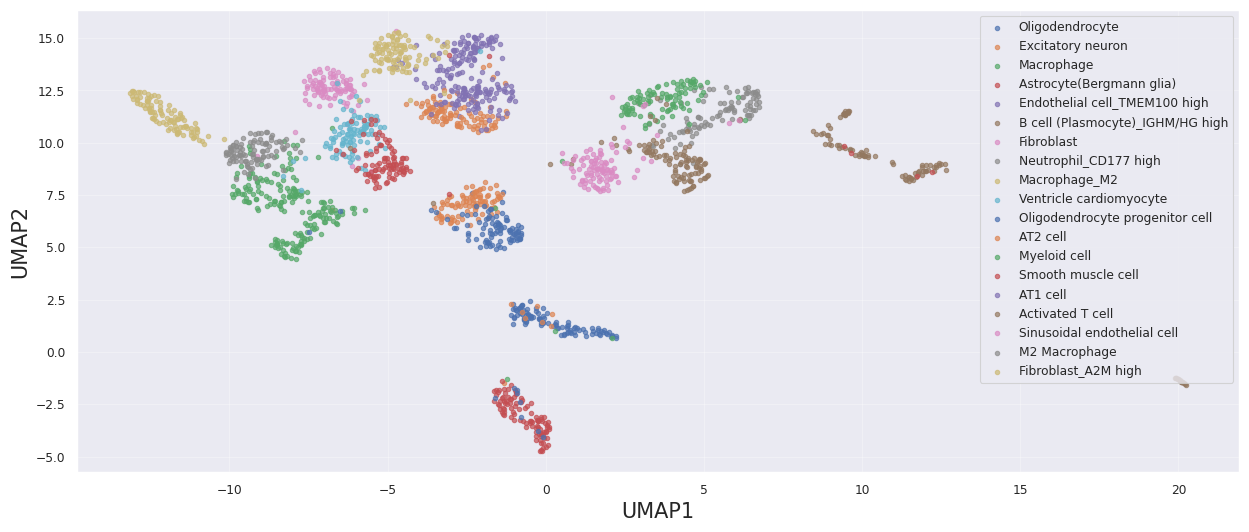

In [21]:
umap_coords = adata_sc.obsm['X_umap']

plt.figure(figsize=(15, 6))
for celltype in df_files["Celltype"].unique():
    cluster_data = df_sc_data.columns.isin(df_files.index[df_files["Celltype"] == celltype])
    plt.scatter(umap_coords[cluster_data, 0], umap_coords[cluster_data, 1], alpha=0.7, s=10, label=celltype)

plt.legend()
plt.xlabel('UMAP1', fontsize=15)
plt.ylabel('UMAP2', fontsize=15)
plt.grid(alpha=0.3)
plt.savefig("%s/umap.pdf"%(directory))
plt.show()